# Image Processing Pipeline Optimization Notebook
This notebook demonstrates how to set up and optimize an image processing pipeline using a large language model (LLM) feedback loop. Each section includes explanations for a university-level understanding.

## 1. Environment Setup and Imports
We import necessary libraries and configure the environment to ensure reproducibility.

In [43]:
# Imports for environment management and scientific computing
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import pytesseract  # OCR tool

# Print versions for reproducibility
print(f"Python version: {sys.version}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

Python version: 3.12.10 (main, Apr 18 2025, 01:42:45) [GCC 14.2.1 20250207]
OpenCV version: 4.11.0
NumPy version: 2.2.4


## 2. Project Root Path Configuration
We add the project root to `sys.path` for module imports from the repository.

In [42]:
# Adjust project root to import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

Project root added: /home/xgen0/CertyChain/CertyLex/backend


## 3. LLM Pipeline Imports
We import the optimized pipeline builders and processing functions from our `lib` directory.

In [41]:
from lib.image.llm_pipeline import optimize_pipeline, build_pipeline, process_image
from ollama import chat  # Ollama client for LLM interactions

## 4. Defining LLM Models and Parameter Space
We specify which LLMs to test and define the hyperparameter search space for each image processing step.

In [44]:
# LLM models available for feedback
models = [
    "llama3.2-vision:11b",
    "deepseek-r1:8b",
    "deepseek-r1:32b"
]

# Hyperparameter search ranges for each step
param_space = {
    "denoise": {"h": [5, 10, 15], "template_window": [3, 7]},
    "contrast": {"alpha": [1.0, 1.2, 1.5], "beta": [0, 10, 20]},
    "resize": {"width": [800, 1024, 1280]},
    "normalize": {"clipLimit": [1.0, 2.0], "tileGrid": [(8, 8)]},
    "crop": {"margin": [0, 5, 10]},
    "hash": {}  # Placeholder for future steps
}
print(param_space)

{'denoise': {'h': [5, 10, 15], 'template_window': [3, 7]}, 'contrast': {'alpha': [1.0, 1.2, 1.5], 'beta': [0, 10, 20]}, 'resize': {'width': [800, 1024, 1280]}, 'normalize': {'clipLimit': [1.0, 2.0], 'tileGrid': [(8, 8)]}, 'crop': {'margin': [0, 5, 10]}, 'hash': {}}


## 5. Generating Random Configuration
Function to sample a random valid configuration from the parameter space.

In [45]:
def generate_random_config():
    return {
        "use": {
            "rotate": random.choice([True, False]),
            "denoise": True,
            "contrast": random.choice([True, False]),
            "resize": True,
            "normalize": True,
            "crop": random.choice([True, False]),
            "hash": True
        },
        "params": {
            "denoise": {"h": 10, "template_window": 7},
            "contrast": {"alpha": 1.2, "beta": 10},
            "resize": {"width": 1024},
            "normalize": {"clipLimit": 2.0, "tileGrid": (8, 8)},
            "crop": {"margin": 5}
        }
    }

# Example random config
print(generate_random_config())

{'use': {'rotate': False, 'denoise': True, 'contrast': False, 'resize': True, 'normalize': True, 'crop': False, 'hash': True}, 'params': {'denoise': {'h': 10, 'template_window': 7}, 'contrast': {'alpha': 1.2, 'beta': 10}, 'resize': {'width': 1024}, 'normalize': {'clipLimit': 2.0, 'tileGrid': (8, 8)}, 'crop': {'margin': 5}}}


## 6. Defining the LLM Prompt Template
Template for requesting adapted pipeline parameters based on image metrics.

In [46]:
# Example of how the prompt is structured for the LLM to decide next steps
prompt_template = '''
An image was processed and the following metrics were evaluated:
- Blur reduction: {blur_reduction:.2f}
- OCR gain: {ocr_gain}
- Overall score: {score:.2f}

Initial parameters:
{params_json}

Decide which steps to enable. Respond only with JSON.
The hash step is always enabled.
'''

print(prompt_template)


An image was processed and the following metrics were evaluated:
- Blur reduction: {blur_reduction:.2f}
- OCR gain: {ocr_gain}
- Overall score: {score:.2f}

Initial parameters:
{params_json}

Decide which steps to enable. Respond only with JSON.
The hash step is always enabled.



## 7. LLM Adjustment Callback
Function to call the LLM and parse its JSON response. Falls back to random config if parsing fails.

In [47]:
def llm_adjust_callback(data, model_name=models[0], custom_prompt=None):
    # Use default prompt if none provided
    prompt = custom_prompt or prompt_template.format(
        blur_reduction=data['metrics']['blur_reduction'],
        ocr_gain=data['metrics']['ocr_gain'],
        score=data['metrics']['score'],
        params_json=json.dumps(data['params'], indent=2)
    )
    response = chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    try:
        return json.loads(response['message']['content'])
    except Exception:
        return generate_random_config()

## 8. Image Quality Evaluation
Compute blur variance and OCR text length to score improvements.

In [53]:
def evaluate_image_quality(orig, proc):
    # Check if processed image is valid
    if proc is None or not isinstance(proc, np.ndarray):
        # Try to recover the last valid image from the pipeline history if available
        # This requires 'steps' and 'history' in the current scope
        try:
            # Use improved_img if available in the notebook context
            if 'improved_img' in globals() and isinstance(improved_img, np.ndarray):
                proc_img = improved_img
            # Or try to reconstruct from steps/history if available
            elif 'steps' in globals() and 'best_result' in globals():
                img = orig.copy()
                for step, entry in zip(steps, best_result['history']):
                    if entry["step"] == "hash":
                        break
                    try:
                        img = step(img)
                    except Exception:
                        break
                proc_img = img
            else:
                proc_img = None
        except Exception:
            proc_img = None

        if proc_img is None or not isinstance(proc_img, np.ndarray):
            return {
                'blur_reduction': -9999,
                'ocr_gain': -9999,
                'score': -9999
            }
        else:
            b_orig = cv2.Laplacian(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
            b_proc = cv2.Laplacian(cv2.cvtColor(proc_img, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
            text_orig = len(pytesseract.image_to_string(orig))
            text_proc = len(pytesseract.image_to_string(proc_img))
            return {
                'blur_reduction': b_proc - b_orig,
                'ocr_gain': text_proc - text_orig,
                'score': (b_proc - b_orig) + (text_proc - text_orig)
            }
    b_orig = cv2.Laplacian(cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
    b_proc = cv2.Laplacian(cv2.cvtColor(proc, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()
    text_orig = len(pytesseract.image_to_string(orig))
    text_proc = len(pytesseract.image_to_string(proc))
    return {
        'blur_reduction': b_proc - b_orig,
        'ocr_gain': text_proc - text_orig,
        'score': (b_proc - b_orig) + (text_proc - text_orig)
    }

## 9. Pipeline Optimization Loop
Iteratively sample configurations and use the LLM feedback to find the best pipeline.

In [ ]:
def optimize_pipeline(orig_image, param_space, llm_call, max_iter=50):
    best = {'score': -float('inf')}
    for _ in range(max_iter):
        # Randomly sample parameters
        current_params = {
            k: {sk: random.choice(v) for sk, v in sp.items()}
            for k, sp in param_space.items()
        }
        # Enable all steps initially
        config = {
            "use": dict.fromkeys(current_params.keys(), True),
            "params": current_params
        }
        steps = build_pipeline(config)
        img, _ = process_image(orig_image, steps)
        metrics = evaluate_image_quality(orig_image, img)

        # Get LLM-adjusted config
        new_config = llm_call({
            "orig": orig_image,
            "proc": img,
            "metrics": metrics,
            "params": current_params
        })
        new_steps = build_pipeline(new_config)
        new_img, history = process_image(orig_image, new_steps)
        new_metrics = evaluate_image_quality(orig_image, new_img)

        # Update best
        if new_metrics['score'] > best['score']:
            best.update({
                'image': new_img,
                'config': new_config,
                'metrics': new_metrics,
                'history': history,
                'score': new_metrics['score']
            })
    return best

## 10. Running Optimization and Visualizing Results
Apply the optimization to an example image and display before/after along with step history.

In [50]:
# Load and process an example image
image_dir = os.path.join(project_root, 'samples', 'data', 'images', 'img_pipeline')

In [51]:
#image1
image1_path = 'rotated.jpg'
image1_path = os.path.join(image_dir, image1_path)

Best Configuration:
 {
  "use": {
    "rotate": false,
    "denoise": true,
    "contrast": false,
    "resize": true,
    "normalize": true,
    "crop": true,
    "hash": true
  },
  "params": {
    "denoise": {
      "h": 10,
      "template_window": 7
    },
    "contrast": {
      "alpha": 1.2,
      "beta": 10
    },
    "resize": {
      "width": 1024
    },
    "normalize": {
      "clipLimit": 2.0,
      "tileGrid": [
        8,
        8
      ]
    },
    "crop": {
      "margin": 5
    }
  }
}
Metrics:
 {'blur_reduction': np.float64(-288.72571045214295), 'ocr_gain': 0, 'score': np.float64(-288.72571045214295)}
{'step': 'denoise', 'status': 'ok', 'input_shape': (640, 993, 3), 'output_shape': (640, 993, 3)}
{'step': 'resize', 'status': 'ok', 'input_shape': (640, 993, 3), 'output_shape': (659, 1024, 3)}
{'step': 'normalize', 'status': 'ok', 'input_shape': (659, 1024, 3), 'output_shape': (659, 1024, 3)}
{'step': 'crop', 'status': 'ok', 'input_shape': (659, 1024, 3), 'output_shap

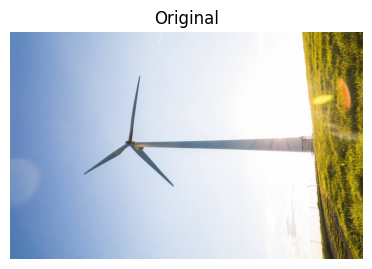

In [55]:
# Utility: Get last valid image before hash step
def get_last_valid_image(orig, history, steps):
    """
    Returns the last valid image before the hash step.
    """
    img = orig.copy()
    for step, entry in zip(steps, history):
        if entry["step"] == "hash":
            break
        try:
            img = step(img)
        except Exception:
            break
    return img

# Load example image
orig = cv2.imread(image1_path)
if orig is None:
    raise ValueError(f"Failed to load image from path: {image1_path}")

best_result = optimize_pipeline(orig, param_space, llm_adjust_callback)

print("Best Configuration:\n", json.dumps(best_result['config'], indent=2))
print("Metrics:\n", best_result['metrics'])

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

# Get improved image before hash step for visualization
from lib.image.llm_pipeline import build_pipeline
steps = build_pipeline(best_result['config'])
improved_img = get_last_valid_image(orig, best_result['history'], steps)

# History of applied steps
for entry in best_result['history']:
    print(entry)

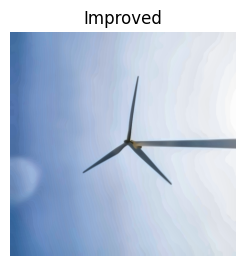

In [56]:
# Display the improved image after optimization
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(improved_img, cv2.COLOR_BGR2RGB))
plt.title("Improved")
plt.axis("off")
plt.show()

## 11. Optimización y comparación con DeepSeek 8B y 32B
Ahora repetimos el proceso de optimización usando los modelos DeepSeek y comparamos los resultados visuales y métricos de los tres modelos.

In [ ]:
# Optimización con DeepSeek 8B
best_result_ds8b = optimize_pipeline(
    orig, param_space,
    lambda data: llm_adjust_callback(data, model_name=models[1], custom_prompt=prompt_template),
    max_iter=30
)
steps_ds8b = build_pipeline(best_result_ds8b['config'])
improved_img_ds8b = get_last_valid_image(orig, best_result_ds8b['history'], steps_ds8b)

In [ ]:
# Optimización con DeepSeek 32B
best_result_ds32b = optimize_pipeline(
    orig, param_space,
    lambda data: llm_adjust_callback(data, model_name=models[2], custom_prompt=prompt_template),
    max_iter=30
)
steps_ds32b = build_pipeline(best_result_ds32b['config'])
improved_img_ds32b = get_last_valid_image(orig, best_result_ds32b['history'], steps_ds32b)

In [ ]:
# Visualización comparativa de los tres modelos
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(improved_img, cv2.COLOR_BGR2RGB))
plt.title("Llama3.2-Vision")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(improved_img_ds8b, cv2.COLOR_BGR2RGB))
plt.title("DeepSeek 8B")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(improved_img_ds32b, cv2.COLOR_BGR2RGB))
plt.title("DeepSeek 32B")
plt.axis("off")
plt.show()

In [ ]:
# Mostrar métricas y configuraciones para comparar
import pandas as pd

results = [
    {
        "Modelo": "Llama3.2-Vision",
        "Score": best_result['metrics']['score'],
        "Blur Reduction": best_result['metrics']['blur_reduction'],
        "OCR Gain": best_result['metrics']['ocr_gain'],
        "Config": json.dumps(best_result['config'], indent=0)
    },
    {
        "Modelo": "DeepSeek 8B",
        "Score": best_result_ds8b['metrics']['score'],
        "Blur Reduction": best_result_ds8b['metrics']['blur_reduction'],
        "OCR Gain": best_result_ds8b['metrics']['ocr_gain'],
        "Config": json.dumps(best_result_ds8b['config'], indent=0)
    },
    {
        "Modelo": "DeepSeek 32B",
        "Score": best_result_ds32b['metrics']['score'],
        "Blur Reduction": best_result_ds32b['metrics']['blur_reduction'],
        "OCR Gain": best_result_ds32b['metrics']['ocr_gain'],
        "Config": json.dumps(best_result_ds32b['config'], indent=0)
    }
]
df = pd.DataFrame(results)
df[["Modelo", "Score", "Blur Reduction", "OCR Gain"]]

**Conclusión:**  
Compara visualmente y numéricamente los resultados de los tres modelos. Si DeepSeek mejora la imagen, puedes ajustar los parámetros de búsqueda o el prompt para obtener aún mejores resultados.